# LightGBM + SHAP Code Tutorial

<b><u>[목적]</u></b>
- Classification Problem으로 항상 변형하여 문제를 풀었지만 이번에는 Regression Problem으로 풀이함
    - GBM Family를 설명하기 전에는 Model의 Complexity를 크게 높이지 못하였기 때문
        - GMB Code Tutorial에서 Classification Problem으로 변형하여 실행시킨 이유는 앞의 RF와 AdaBoost와의 정확도 차이를 보여주고 싶었음
- XGBoost, LightGBM은 빅데이터를 빠르게 학습함과 동시에 Model Complexity를 무한으로 늘릴 수 있음
    - 따라서 Regression Problem으로 해결
- SHAP를 활용하여 내가 원하는 데이터에 대하여 Local Importance Score를 산출함

<b><u>[Process]</u></b>
- Data Path = 'https://github.com/GonieAhn/Data-Science-online-course-from-gonie/tree/main/Data%20Store'
- Define X's & Y
- Split Train & Valid data set
- Modeling
- Data Picking
- SHAP
- 해석

<b><u>[주의]</u></b>
- Tutorial Code가 있는 폴더에 "LightGBM_model"라는 폴더를 만들어줌
- 생성한 폴더에 Hyperparameter를 Tuning 하면서 모델을 모두 저장함

<b><u>[Thinking]</u></b>
- 내가 Target 한 데이터에 대해 여러가지 원인이 존재한다면 어떻게 해야할까?
    - 나는 알고 있음

In [1]:
import shap
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, mean_squared_error

In [2]:
%%time
# Data Load 
data = pd.read_csv("../Data Store/TOY_DATA.csv")
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 355)
Wall time: 234 ms


<b><u>[Data Condition Check]</u></b>
- Data Condition
    - 그 전 Tutorial에서는 Missing Value에 대한 Row를 모두 삭제함
    - 이번에는 살려둠
    - 변수는 Missing Percentage와 Level(Unique) 값에 따라 삭제함

In [3]:
# Feature Name Cleaning
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [4]:
%%time
# Data Checking
col = []
missing = []
level = [] 
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 345)
Wall time: 358 ms


In [5]:
drop_col

57      X57
59      X59
108    X108
114    X114
132    X132
140    X140
151    X151
344    X344
353    X353
354    X354
Name: name, dtype: object

In [6]:
# Regression Problem
Y = data['Y']
X = data.drop(columns=['Y', 'X1', 'X2', 'X3'])

idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))

>>>> # of Train data : 2450
>>>> # of valid data : 1050


<b><u>[LightGBM]</u></b>
- Hyperparameter tuning
    - n_estimators, learning_rate, max_depth, reg_alpha
    - LightGBM은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
    - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음
        - Tip : Classification Problem보다 Complexity를 더 높게 가져가야함
    - 내가 많이 해봤음

In [7]:
# Parameter Tuning - Reference : https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

# n_estimators
n_tree = [100, 300, 500, 700]
# learning_rate
l_rate = [0.05, 0.1]
# max_depth
m_depth = [18, 36]
# reg_alpha
L1_norm = [0.1, 1]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
save_acc = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:
                
                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = LGBMRegressor(n_estimators=n, learning_rate=l, 
                                       max_depth=m, reg_alpha=L1, 
                                       n_jobs=-1)
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])
                
                
                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                mse = mean_squared_error(Y.iloc[train_idx], y_pre_train)
                r2 = np.corrcoef(Y.iloc[train_idx], y_pre_train)[0, 1]**2
                print('>>>> Train Mean squared error: ', mse)
                print('>>>> Train R2 score: ', r2)

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                mse = mean_squared_error(Y.iloc[valid_idx], y_pre_test)
                r2 = np.corrcoef(Y.iloc[valid_idx], y_pre_test)[0, 1]**2
                print('>>>> Test Mean squared error: ', mse)
                print('>>>> Test R2 score: ', r2)
                
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                save_acc.append(r2)
                
                joblib.dump(model, './LightGBM_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(save_acc[-1], 4)))
                gc.collect()

>>> 0 <<<
n_estimators : 100, learning_rate : 0.05, max_depth : 18, reg_alpha : 0.1
>>>> Train Mean squared error:  0.0023229622663342286
>>>> Train R2 score:  0.8225943793012058
>>>> Test Mean squared error:  0.009019338907825638
>>>> Test R2 score:  0.24909223679358622
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 100, learning_rate : 0.05, max_depth : 18, reg_alpha : 1
>>>> Train Mean squared error:  0.003357752151264934
>>>> Train R2 score:  0.7274898367264143
>>>> Test Mean squared error:  0.009245610549052596
>>>> Test R2 score:  0.229943863778121
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 100, learning_rate : 0.05, max_depth : 36, reg_alpha : 0.1
>>>> Train Mean squared error:  0.0023229622663342286
>>>> Train R2 score:  0.82259437930

In [8]:
print(">>> {} <<<\nBest Test Acc : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_Depth : {}\nBest L1-norm term : {}".format(np.argmax(save_acc),
                                                                                                                                            save_acc[np.argmax(save_acc)], 
                                                                                                                                            save_n[np.argmax(save_acc)],
                                                                                                                                            save_l[np.argmax(save_acc)],
                                                                                                                                            save_m[np.argmax(save_acc)],
                                                                                                                                            save_L1[np.argmax(save_acc)]))

>>> 0 <<<
Best Test Acc : 0.24909223679358622
Best n_estimators : 100
Best Learning Rate : 0.05
Best Max_Depth : 18
Best L1-norm term : 0.1


In [9]:
 
# Model Loading
model = joblib.load("./LightGBM_model/Result_{}_{}_{}_{}_{}.pkl".format(save_n[np.argmax(save_acc)],
                                                                       save_l[np.argmax(save_acc)],
                                                                       save_m[np.argmax(save_acc)],
                                                                       save_L1[np.argmax(save_acc)],
                                                                       round(save_acc[np.argmax(save_acc)], 4)))
 

In [10]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])[:20]
print(feature_map)

    Score Feature
0     132     X23
1      69     X22
2      58    X253
3      50    X265
4      45     X16
5      44    X236
6      42    X247
7      40    X261
8      37    X267
9      37    X263
10     37     X11
11     35    X275
12     34     X20
13     33      X8
14     33    X274
15     33    X269
16     33    X268
17     33    X266
18     32    X279
19     32    X242


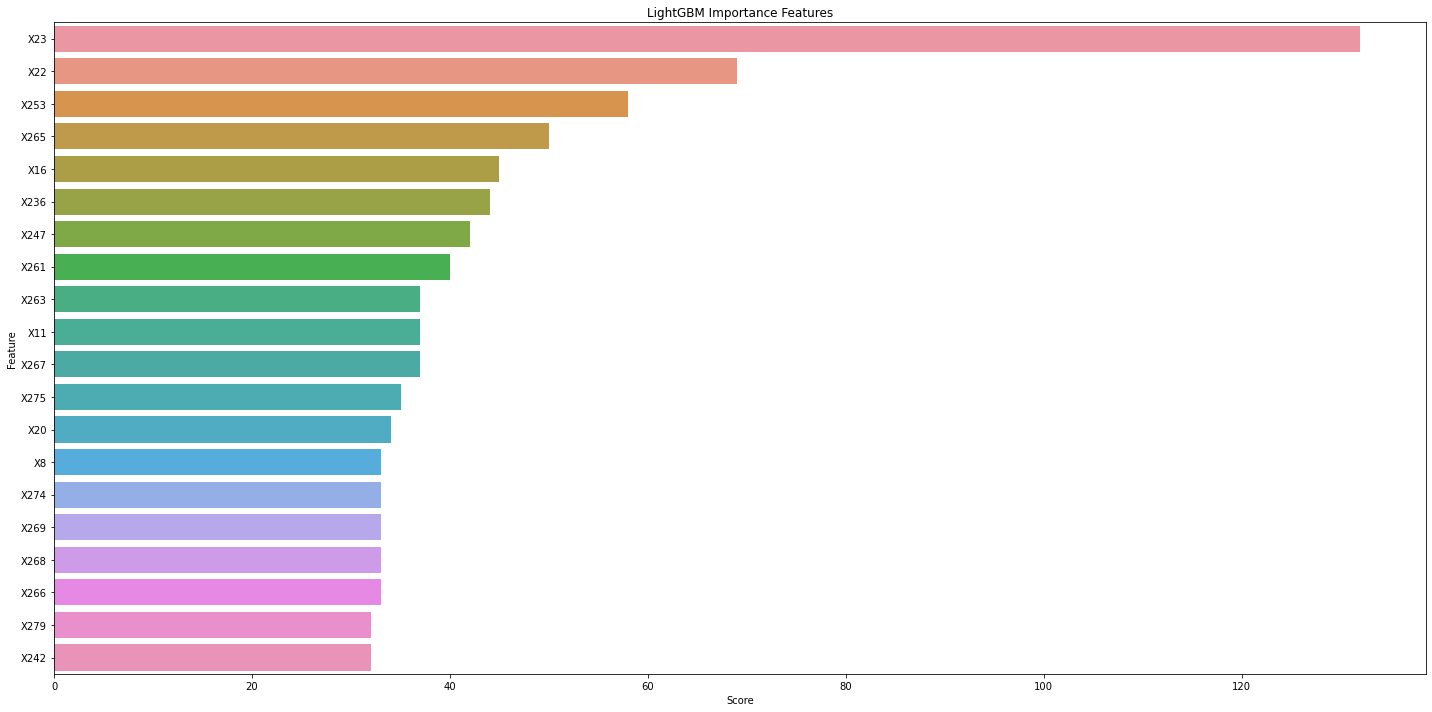

In [11]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('LightGBM Importance Features')
plt.tight_layout()
plt.show()

<b><u>[SHAP Global Feature Importance Score]</u></b>
- 기존 모델에서 제공하는 Feature Importance Score와 다르게 SHAP는 변수의 방향성에 대해 해석할 수 있음
    - 마치 단순 Regression의 계수 처럼 --> 완전 강력한 기능
- 모든데이터에 대해서 구하기에는 시간이 너무 많이 걸림
- 모든데이터마다 CASE Simple App를 해야되기 때문
- 이번 튜터리얼에서는 모든 데이터에 대해 SHAP Value를 산출해봄
    - 데이터가 10,000개 넘어갈 때는 비추
    - 내가 원하는 데이터에 대해서 그리는 걸 추천함
- SHAP를 활용하여 Global Feature Importance Score를 산출해보고 해석도 해봄
- 쥬피터노트북 Cell[13]를 기준으로 해석을 진행함
    - "X23"의 경우 값이 낮으면 낮을 수록 고효율에 영향을 많이 미치고, 값이 높으면 높을 수록 저효율에 영향을 많이 미침
    - 나머지 변수도 위와 같이 해석을 진행할 수 있음

In [12]:
# Explanier making (Build Up)
sample_idx = list(range(0, X.shape[0],10))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

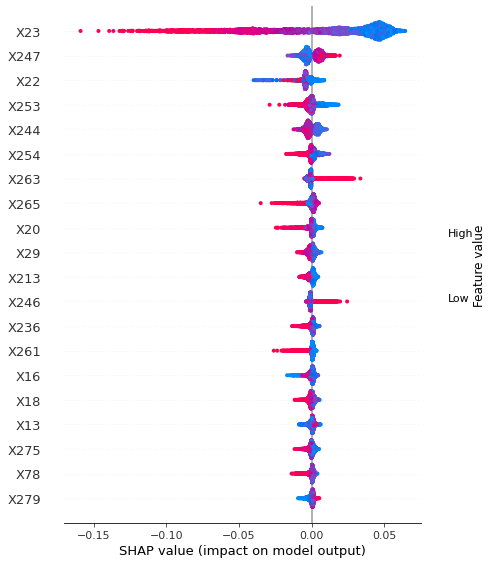

In [13]:
# 중요 변수 별 영향도 및 방향성 Plotting
shap.summary_plot(shap_values, X)

<b><u>[Data Picking - 중요 !]</u></b>
- 고효율군 상위 10% 만을 추출함
    - 고효율군에 대한 원인을 알고 싶기 때문(Biz 영역 - 다른 Biz로 다른 데이터 선택 가능)
- 고효율군 상위 10%에서 MSE가 낮은(학습을 잘한 데이터, Pattern이 확실한 데이터) 데이터만 추출함
    - MSE가 낮다는 것은 학습을 잘 했다는 것
        - MSE가 낮은 데이터는 원인분석을 해도 유의미 함 !
    - MSE가 높다는 것은 학습을 잘 하지 못했다는 것
        - MSE가 높은 데이터는 원인분석을 해도 의미가 없음 ! 

In [15]:
# Cutting
y_cut = np.percentile(data['Y'], 90)
print(y_cut)

0.8838753059


In [16]:
# Total Data Prediction
total = model.predict(X)

In [18]:
# Total Data Cal MSE
total_Y = pd.concat([Y, pd.DataFrame(total, columns=['Pred'])], axis=1)
total_Y['MSE'] = np.sqrt((total_Y['Y'] - total_Y['Pred'])**2)

In [19]:
total_Y

,Y,Pred,MSE
0,0.824328,0.792025,0.032303
1,0.599022,0.596977,0.002045
2,0.665648,0.686759,0.021111
3,0.898533,0.804805,0.093728
4,0.804218,0.789128,0.015089
...,...,...,...
3495,0.727995,0.710561,0.017434
3496,0.775672,0.754064,0.021609
3497,0.856174,0.837810,0.018363
3498,0.725672,0.682706,0.042967


In [22]:
# Data Picking step : y_cut & MSE Top 10 
tmp = total_Y.iloc[valid_idx]
tmp = tmp[tmp['Y'] >= y_cut].sort_values(by='MSE')
pick_index = list(tmp.iloc[:10].index)

In [23]:
pick_index

[333, 162, 3258, 297, 1181, 2513, 3112, 282, 2504, 1511]

<b><u>[Explanations]</u></b>
- 고효율 & MSE가 낮은 Top 10에 대해 데이터 각각의 중요 인자를 추출해봄
- 해석
    - idx : 333
    - base value 보다 큰 0.87의 값을 갖음
    - base value 보다 큰 이유는 X23과 X247이 가장 영향을 많이 줬음
    - Top 10 모든 index에서 X23이 가장 지대한 영향을 미치고 있음
    - 2위로 영향을 미치는 변수는 각각 조금씩 다름

333
162
3258
297
1181
2513
3112
282
2504
1511


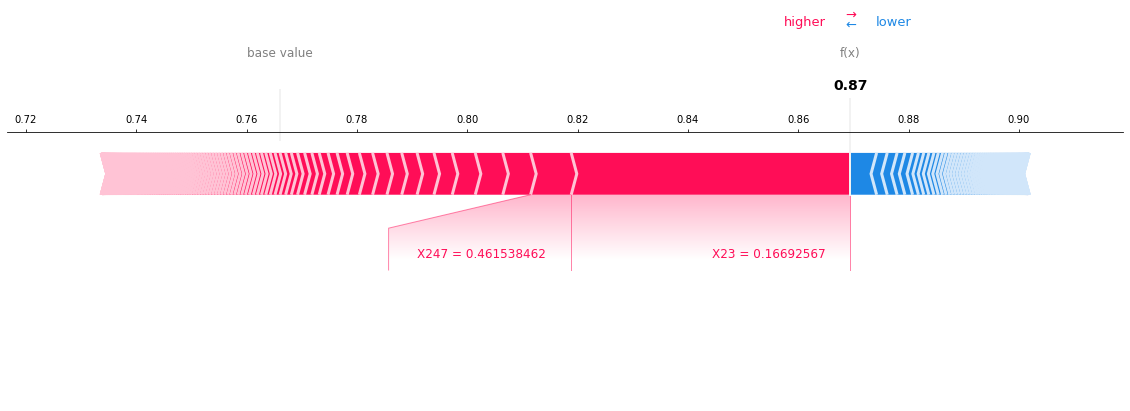

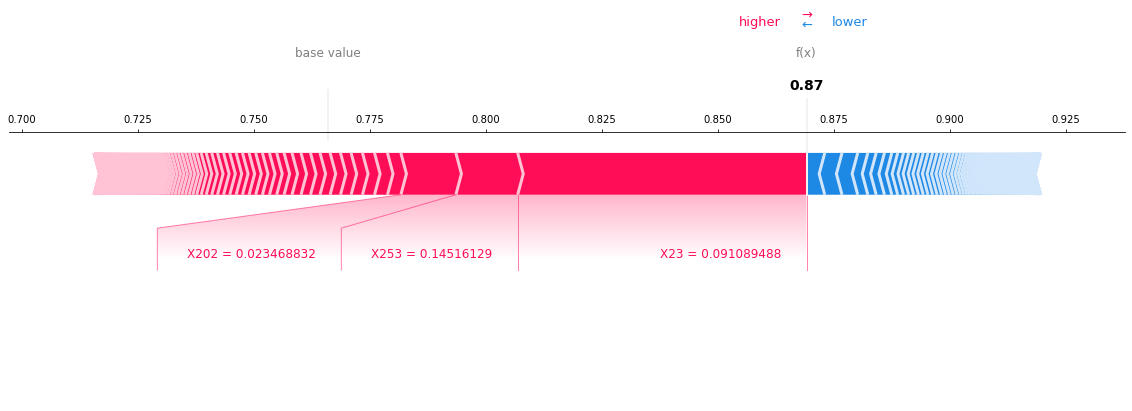

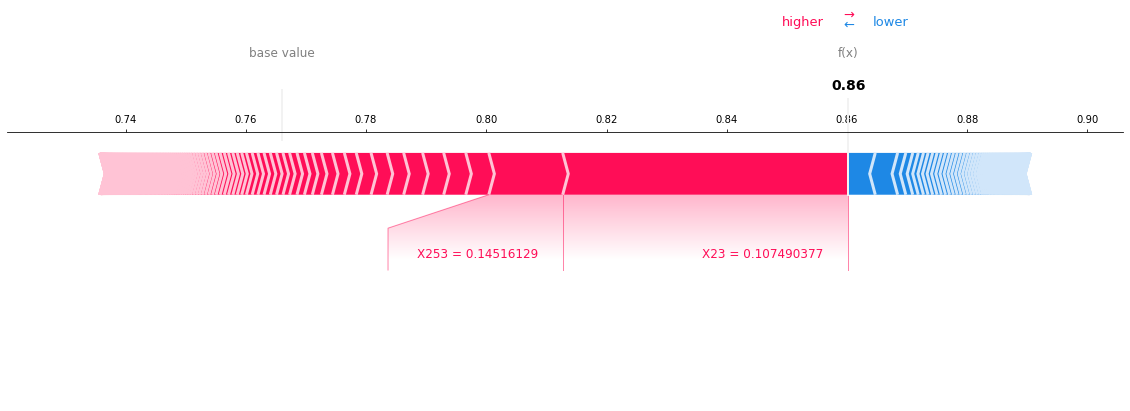

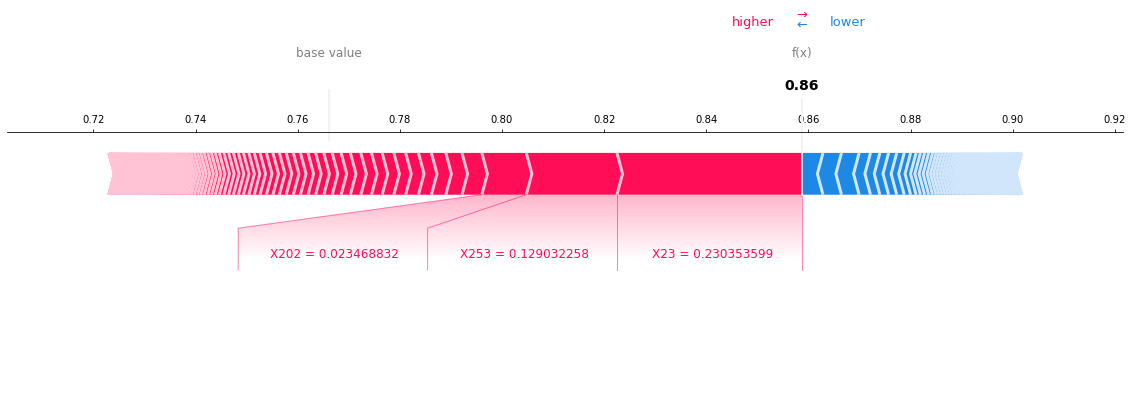

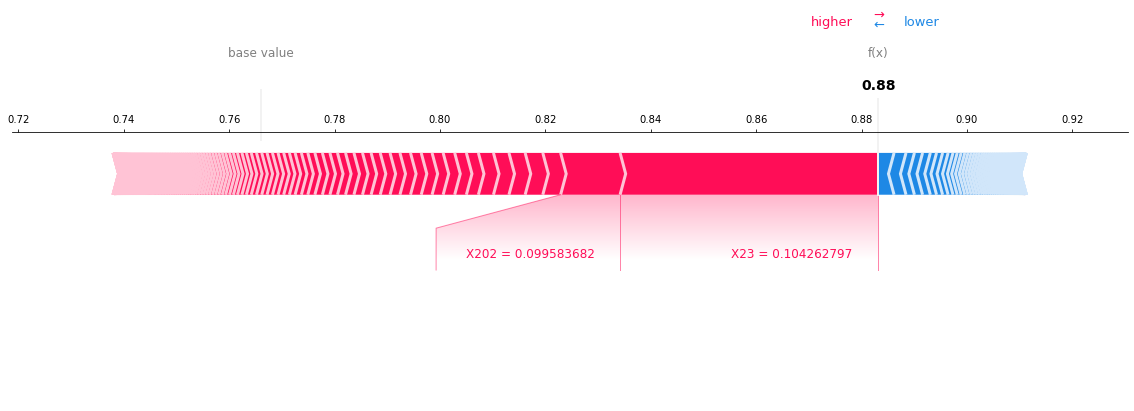

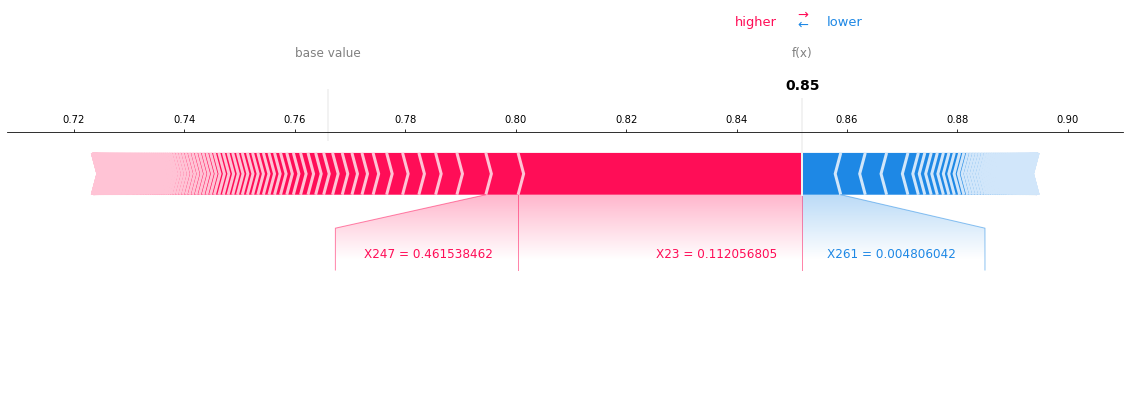

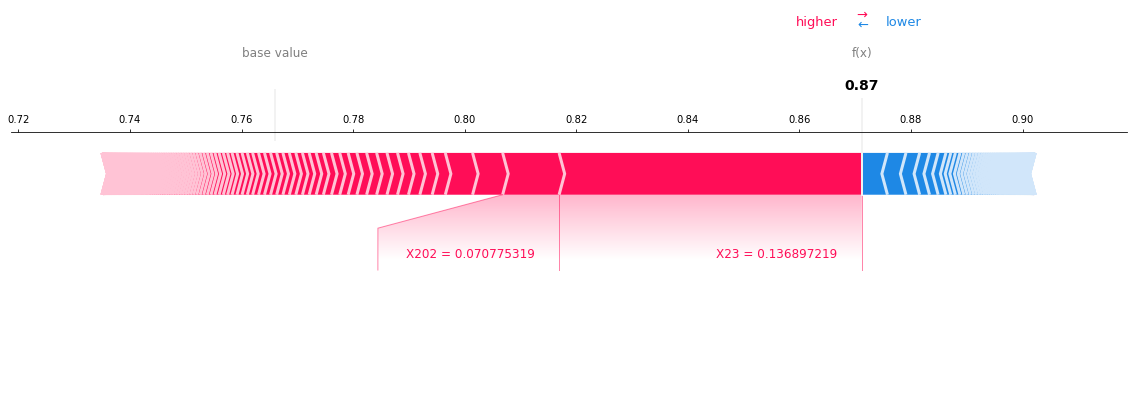

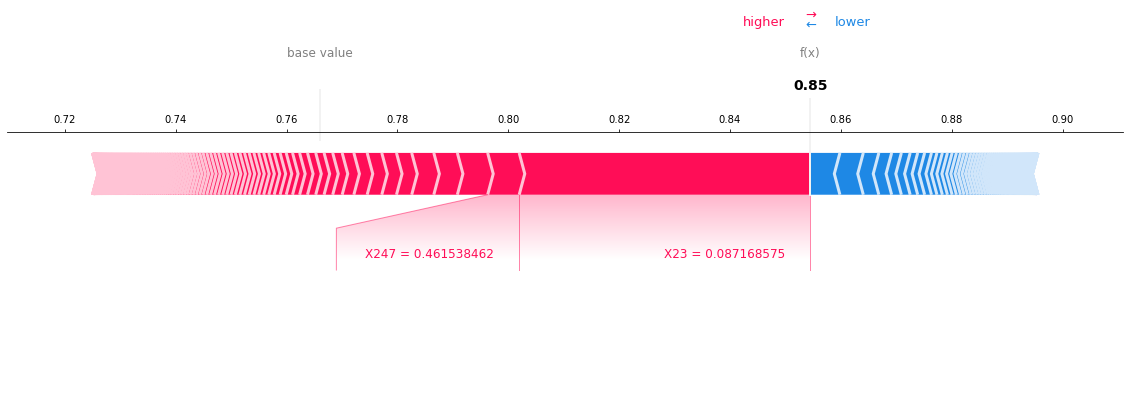

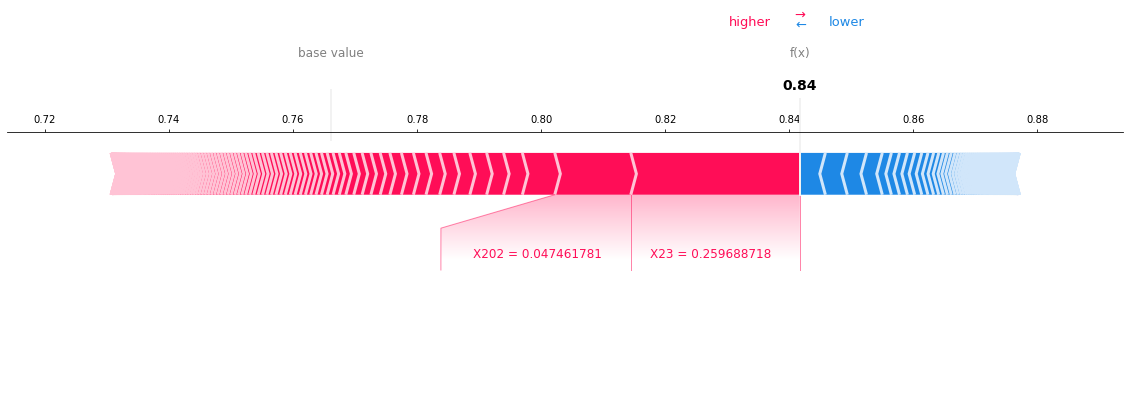

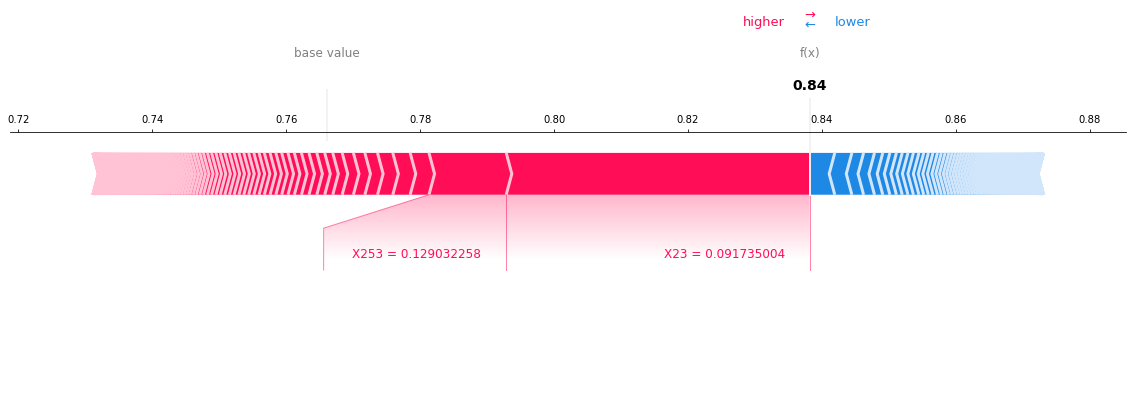

In [26]:
# Plotting
shap.initjs()
for i, idx in enumerate(pick_index):
    print(idx)
    shap.force_plot(explainer.expected_value, shap_values[idx], X.iloc[idx, :], figsize=(20,5), matplotlib=True, show=False)